In [69]:
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils
import yieldcurve as yc

In [4]:
portfolio, market = utils.load_data()
NOW = utils.set_now()

In [90]:
def cashflow(rate=0, maturity=1, volume=1, payment_type='BULLET'):
    if payment_type == 'BULLET':
        interest = np.full(maturity, rate) * volume
        capital = np.zeros(maturity)
        capital[-1] = volume
        remaining = np.full(maturity, volume)-capital
        cashflow = capital + interest
    elif payment_type == 'LINEAR':
        # Calculate capital
        capital = np.repeat(1/maturity, maturity) * volume
        # Calculate remaining balance after each capital payment
        remaining = np.hstack([volume, volume - np.cumsum(capital)])
        # Calculate interest payment for each period
        interest = remaining[:maturity] * rate
        # Calculate total cash flow for each period
        cashflow = capital + interest
#     elif payment_type == 'ANNUITY':
#         interest = np.zeros(maturity)
#         capital = np.zeros(maturity)
#         cashflow = np.zeros(maturity)
#         remaining = volume
#         if isinstance(rate, (int, float)):
#             rate = np.full(maturity, rate)
#         for i in range(maturity):
#             discount_factor = 1 - (1 + rate[i]) ** -(maturity - i + 1)
#             cashflow[i] = (rate[i] / discount_factor) * remaining if rate[i] != 0 else remaining / (maturity - i + 1)
#             interest[i] = remaining * rate[i]
#             capital[i] = cashflow[i] - interest[i]
#             remaining -= capital[i]

    cf_df = pd.DataFrame({'cashflow': cashflow, 'interest': interest, 'capital': capital, 'remaining': remaining})
    return cf_df

In [91]:
volume = 75000
maturity = 36
rate = 0.01
bull = cashflow(rate,maturity,volume,payment_type="BULLET")

In [66]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

class YieldCurve:
    def __init__(self, curve_type):
        """ Initialize parameters """
        self.curve_type = curve_type
        self._data = None
        self._plot = False
        self._curve = None
        self._status = None
        
    def fit(self, market_data, plot=False):
        """ Fit Nelson-Siegel-Svensson model to the observed yields """
        # Copy market data for the curve type
        self._data = market_data[market_data['type'] == self.curve_type].copy()
        # Calculate time difference in years between now and expiry
        self._data['maturity'] = self._data['date'].apply(lambda date: utils.time_difference_years(date, NOW))
        # Fit the Nelson-Siegel-Svensson model to our yield data
        self._curve, self._status = calibrate_nss_ols(np.ravel(data['maturity']), np.ravel(data['rate']))
        
        self._plot = plot
        if self._plot:
            self._plot_yield()
        
    def _plot_yield(self):
        """ Plot the observed yields and the Nelson-Siegel-Svensson model """
        # Plot observed yield
        plt.scatter(self._data['maturity'], self._data['rate'],
                    label='Observed Yields', marker='o', color='black', s=10)
        # Plot Nelson-Siegel-Svensson model
        plt.plot(self._data['maturity'], self._curve(self._data['maturity']),
                 label='Nelson-Siegel-Svensson', color = 'gray', linestyle='-')
        # Format the figure
        plt.title('Yield Curve')
        plt.xlabel('Maturity time in years')
        plt.ylabel('Yield in %')
        plt.legend()
        # Show plot
        plt.show()
        

In [67]:
data=spot_yield_curve(market, 'EUR01')

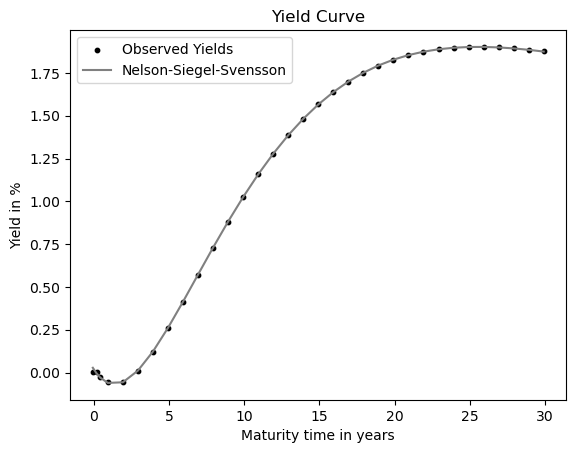

In [68]:
EUR01 = YieldCurve(curve_type='EUR01')
EUR01.fit(market, plot=True)

      fun: 0.0003116488407276471
 hess_inv: array([[ 15277.83659634, -14094.84401443],
       [-14094.84401443,  13557.7508673 ]])
      jac: array([-1.98023918e-06, -3.58159377e-06])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 24
     njev: 30
   status: 0
  success: True
        x: array([6.15580738, 6.06451028])

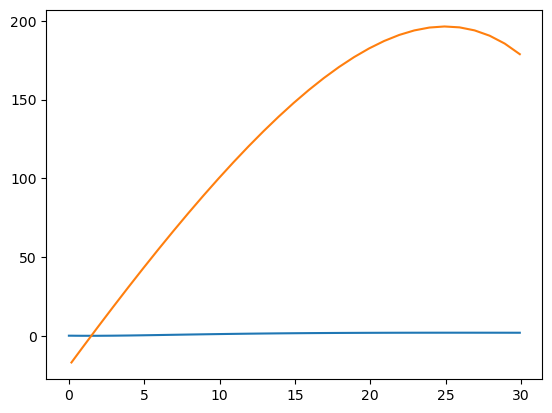

In [72]:
plt.plot(data['maturity'], data['rate'])
plt.plot(data['maturity'], data['maturity'].apply(lambda date: svensson_model(date, *params)))

In [83]:

t = np.ravel(data['maturity'])
y = np.ravel(data['rate'])
curve, status = calibrate_nss_ols(t, y)  # starting value of 1.0 for the optimization of tau
print(status.success)
print(curve)

True
NelsonSiegelSvenssonCurve(beta0=0.7543648266838947, beta1=-0.7375177319383158, beta2=329.84991515939674, beta3=-327.330597645603, tau1=6.155807375041321, tau2=6.0645102801806905)


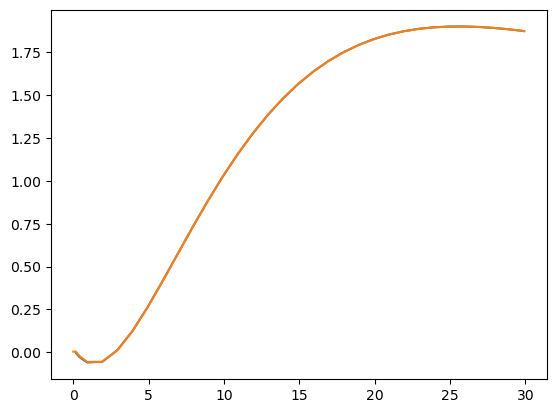

In [89]:
plt.plot(data['maturity'], curve(data['maturity']))
plt.plot(data['maturity'], data['rate'])

In [88]:
curve(data['maturity'])-data['rate']

0          NaN
1    -0.007800
2    -0.005830
3    -0.003494
4    -0.000131
5     0.001345
6     0.001646
7     0.001319
8     0.001147
9     0.000496
10   -0.000099
11   -0.000573
12   -0.000520
13   -0.000732
14   -0.000817
15   -0.000798
16   -0.000456
17   -0.000340
18   -0.000193
19   -0.000036
20    0.000242
21    0.000350
22    0.000432
23    0.000481
24    0.000540
25    0.000500
26    0.000423
27    0.000312
28    0.000165
29   -0.000017
30   -0.000224
31   -0.000453
32   -0.000730
dtype: float64

In [87]:
data['rate']-data

0     0.003000
1     0.003363
2    -0.023536
3    -0.056919
4    -0.056542
5     0.010160
6     0.121095
7     0.259506
8     0.412836
9     0.571827
10    0.729794
11    0.882046
12    1.025425
13    1.157938
14    1.278473
15    1.386569
16    1.482237
17    1.565825
18    1.637910
19    1.699219
20    1.750561
21    1.792789
22    1.826761
23    1.853320
24    1.873272
25    1.887379
26    1.896353
27    1.900848
28    1.901462
29    1.898740
30    1.893170
31    1.885189
32    1.875188
Name: rate, dtype: float64

,type,date,rate,comment,maturity_years,maturity
0,EUR01,2014-09-01,0.300000,1M,-0.079398,0.000000
1,EUR01,2014-12-01,0.336256,3M,0.169747,0.169747
2,EUR01,2015-03-01,-2.353646,6M,0.416153,0.416153
3,EUR01,2015-09-01,-5.691876,1Y,0.919918,0.919918
4,EUR01,2016-09-01,-5.654177,2Y,1.921971,1.921971
5,EUR01,2017-09-01,1.015958,3Y,2.921287,2.921287
6,EUR01,2018-09-01,12.109512,4Y,3.920602,3.920602
7,EUR01,2019-09-01,25.950572,5Y,4.919918,4.919918
8,EUR01,2020-09-01,41.283558,6Y,5.921971,5.921971
9,EUR01,2021-09-01,57.182677,7Y,6.921287,6.921287
